![](img/563_banner.png)

# Lecture 1: K-Means Clustering 

UBC Master of Data Science program, 2023-24

Instructor: Varada Kolhatkar

## Lecture plan, imports, and learning outcomes 

### Lecture plan

- Course introduction (~2 mins)
- Clustering activity (~8 mins)
- Summary of the following pre-watch videos (~15 mins)
    - Clustering motivation ([video](https://youtu.be/caAuUAXwpb8))
    - K-Means clustering algorithm ([video](https://youtu.be/s6AvSZ1_l7I))
    - Choosing K ([video](https://youtu.be/M5ilrhcL0oY))
- iClicker questions (~10 mins)     
- Break (~5 mins)
- Introduction to GMMs (~20 mins)
- Demo: Clustering images (~15 mins)
- Final comments and summary (~5 mins)

### Imports

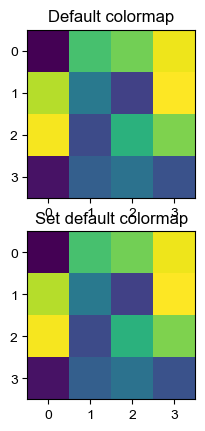

In [1]:
import os
import random
import sys
import time

import numpy as np
import pandas as pd

sys.path.append(os.path.join(os.path.abspath("."), "code"))
import matplotlib.pyplot as plt

from plotting_functions import *
from sklearn import cluster, datasets, metrics
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

#plt.style.use("seaborn")

plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (5, 4)

### Learning outcomes

From this lecture, students are expected to be able to:

- Explain the unsupervised paradigm. 
- Explain the motivation and potential applications of clustering. 
- Define the clustering problem. 
- Broadly explain the K-Means algorithm and apply `sklearn`'s `KMeans` algorithm.  
- Point out pros and cons of K-Means and the difficulties associated with choosing the right number of clusters.   
- Create the Elbow plot and Silhouette plots for a given dataset. 
- Broadly explain the idea of Gaussian mixture models (GMMs) and the differences between K-Means and GMMs.   
- Broadly explain the covariance type hyperparameter of GMMs. 
- Broadly explain model selection in GMMs. 
- Broadly explain the difference between soft cluster assignment vs. hard cluster assignment.  
- Use clustering for the problem of image clustering and interpret clusters. 
- Demonstrate how input data representation can influence clustering results. 

<br><br><br><br>

## Clustering Activity (~5 mins)

Pick any of the two questions below and answer them in [this Google doc](https://docs.google.com/document/d/1Gz2k3QCYYakypS6RYKGUYLvpZ5OyIz7KwnzblbBMSnE/edit?usp=sharing).

![](img/food-clustering-activity.png)

- Categorize the food items in the image and write your categories. Do you think there is one correct way to cluster these images? Why or why not?
- If you want to build a machine learning model to cluster such images how would you represent such images?

<br><br><br><br>

## 1. Clustering motivation [[video](https://youtu.be/caAuUAXwpb8)]

### 1.1 What is clustering? 

- Most of the data out there is unlabeled.  
- Getting labeled training data is often difficult, expensive, or simply impossible in some cases. 
- Can we extract some useful information from unlabeled data? 
- The most intuitive way is to group similar examples together to get some insight into the data even though we do not have the targets.  


**Clustering** is the task of partitioning the dataset into groups called clusters based on their similarities.

The goal of clustering is to discover underlying groups in a given dataset such that:
- examples in the same group are as similar as possible;
- examples in different groups are as different as possible.          

### 1.2 Clustering: Input and (possible) output

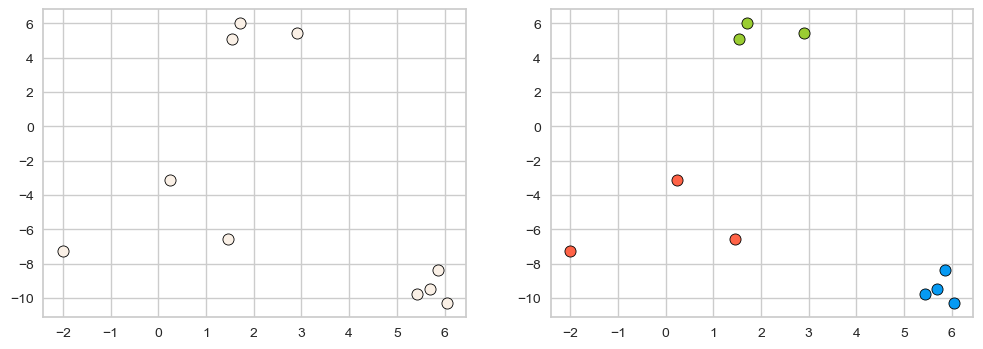

In [2]:
X, y = make_blobs(n_samples=10, centers=3, n_features=2, random_state=10)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
discrete_scatter(X[:, 0], X[:, 1], ax = axes[0]); # user-defined plotting function defined in code/plotting_functions.py
discrete_scatter(X[:, 0], X[:, 1], y=y, markers='o', ax = axes[1]);

One way to think of clustering is the task of colouring the given set of points (e.g., blue, red, green) such that points with the same color are close to each other. 

- Usually the clusters are identified by a **cluster label**. 
- These labels are arbitrary, and relabeling the points (label switching) does not make a difference. 
- What we care about is which points have the same labels and which ones have different labels. 
- Very often we do not know how many clusters are there in the data or if there are any clusters at all. In real-world data, clusters are rarely as clear as in our toy example above. 
- There is a notion of coherent and semantically meaningful clusters in some sense but there is no absolute truth here. 

#### Example 1: What is "correct" grouping?
Which of the following grouping of emoticons is the "correct" grouping?

![](img/emoticon_clustering_example.png)

<!-- <img src="img/emoticon_clustering_example.png" alt="" height="800" width="800">  -->

Both seem reasonable! 

- In clustering, meaningful groups are dependent on the **application**.
- It usually helps if we have some prior knowledge about the data and the problem.   
- This makes it hard for us to objectively measure the quality of a clustering algorithm (or think about "true" clusters).

### 1.3 Common applications

#### Data exploration
Although there is no notion of the "right" answer, we might still get something useful out of clustering. There are a number of common applications for clustering. 

- Summarize or compress data. 
- Partition the data into groups before further processing. 
- For instance, you could use it in supervised learning setting as follows. Carry out clustering and examine performance of your model on individual clusters. If the performance is lower on a particular cluster, you could either try building a separate model for that cluster and improve the overall performance of your supervised model. 

#### Customer segmentation

- Understand landscape of the market in businesses and craft targeted business or marketing strategies tailored for each group.

![](img/customer-segmentation.png)

<!-- <img src="img/customer-segmentation.png" alt="" height="600" width="600">  -->

[source](https://www.youtube.com/watch?v=zPJtDohab-g&t=134s)

#### Document clustering

Grouping articles on different topics from different news sources. For example, [Google News](https://news.google.com). 

![](img/google_news.png)

<!-- <img src="img/google_news.png" alt="" height="1200" width="1200">  -->
    
**You'll be working on document clustering, image clustering, and multimodal clustering in the lab.**

### Other applications
- Social network analysis
- Medical imaging (image segmentation, image grouping, anomaly detection)
- Imputing missing data, data compression, privacy preservation 

<br><br><br><br><br><br>

## 2. K-Means clustering [[video](https://youtu.be/s6AvSZ1_l7I)]

- Clustering is based on the notion of similarity or distances between points. 
- How do we determine similarity between points in a multi-dimensional space?
- Can we use something like $k$-neighbours for similarity? 
    - Yes! That's a good start!  
    - With $k$-neighbours we used Euclidean distances to find nearby points. 
    - We can use the same idea for clustering! 

K-Means is one of the most commonly used clustering algorithms. 

**Input**
- `X` $\rightarrow$ a set of data points  
- `K` (or $k$ or `n_clusters`) $\rightarrow$ number of clusters

**Output**
- `K` clusters (groups) of the data points 



- Before understanding the algorithm, let's try it with `sklearn`. 
- Consider the toy dataset above. 
- For this toy dataset, the three clusters are pretty clear.  

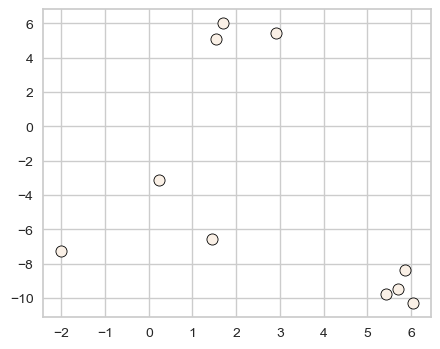

In [3]:
X, y = make_blobs(n_samples=10, centers=3, n_features=2, random_state=10)
discrete_scatter(X[:, 0], X[:, 1]);

Let's try `sklearn`'s `KMeans` algorithm on this dataset.

- First, let's decide how many clusters we want. 
- Let's pass `n_clusters = 3` in this toy dataset. 
- When we call `fit`, we are only passing `X` because this is unsupervised learning; we do not have labels.  

In [4]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, n_init='auto')
kmeans.fit(X); # We are only passing X because this is unsupervised learning

- The output of `KMeans` is `n_clusters` clusters (groups) of the data points. 
- Calling `predict` on the `KMeans` object gives us the cluster assignment for each data point. 

In [5]:
clust_labels = kmeans.predict(X)
clust_labels

array([1, 0, 2, 0, 1, 1, 2, 2, 0, 1], dtype=int32)

We can also access these labels with the `labels_` attribute of `KMeans` object. 

In [6]:
kmeans.labels_

array([1, 0, 2, 0, 1, 1, 2, 2, 0, 1], dtype=int32)

In [7]:
toy_clust_df = pd.DataFrame(X, columns = ['feat1', 'feat2'])
toy_clust_df['cluster labels'] = clust_labels
toy_clust_df

,feat1,feat2,cluster labels
0,5.691924,-9.476412,1
1,1.707899,6.004352,0
2,0.236210,-3.119100,2
3,2.901595,5.421215,0
4,5.859439,-8.381924,1
5,6.047749,-10.305047,1
6,-2.007588,-7.247439,2
7,1.454677,-6.583872,2
8,1.536362,5.111215,0
9,5.430704,-9.759561,1


In K-Means each cluster is represented by its **cluster center**. Let's examine these cluster centers from the `kmeans` object above. 

In [8]:
cluster_centers = kmeans.cluster_centers_
cluster_centers

array([[ 2.04861878,  5.51226051],
       [ 5.75745416, -9.48073598],
       [-0.10556679, -5.65013704]])

Let's plot clustered data points and their corresponding centers. 

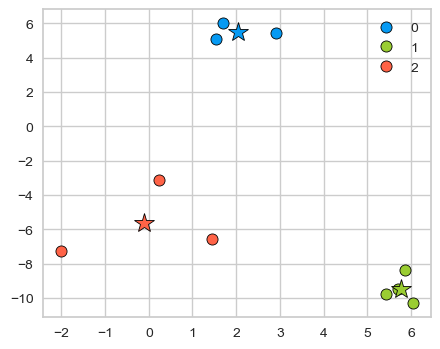

In [9]:
km_labels = kmeans.labels_
discrete_scatter(X[:, 0], X[:, 1], kmeans.labels_, c=kmeans.labels_, markers="o");
plt.legend();
discrete_scatter(cluster_centers[:, 0], cluster_centers[:, 1], y =[0,1,2], s=15, markers='*');

Cluster centers are shown with stars. They are the average of observations in a cluster and so not usually one of the data points. These centers are also referred to as **centroids**. 

With a fitted K-Means object, we can also use `predict` on unseen examples!  

Consider the two new query points shown with triangles below. 

In [10]:
new_examples = np.array([[-2, -2.5], [2, 4]])
kmeans.predict(new_examples)

array([2, 0], dtype=int32)

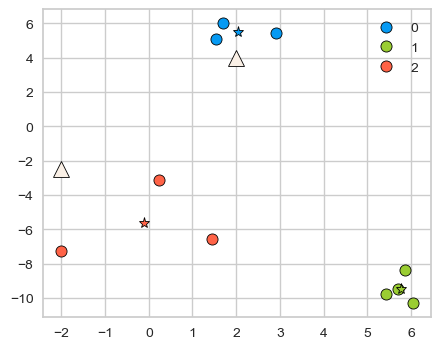

In [11]:
discrete_scatter(X[:, 0], X[:, 1], kmeans.labels_, markers="o")
plt.legend()
discrete_scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], y=[0,1,2], markers="*"
);
discrete_scatter(new_examples[:, 0], new_examples[:, 1], markers="^",s=11);

In [12]:
kmeans.predict(new_examples).tolist()

[2, 0]

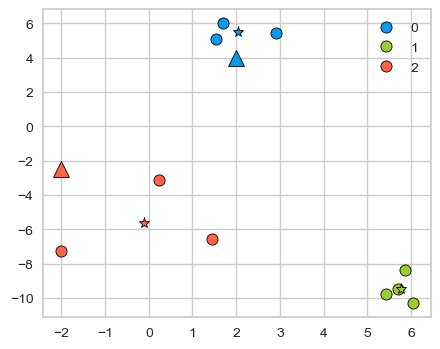

In [13]:
discrete_scatter(X[:, 0], X[:, 1], kmeans.labels_, markers="o")
plt.legend()
discrete_scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], y=[0,1,2], markers="*"
);
discrete_scatter(new_examples[:, 0], new_examples[:, 1], y=kmeans.predict(new_examples).tolist(), markers="^",s=11);

### 2.2 K-Means algorithm

- The main idea is to represent each cluster by its cluster center and assign a cluster membership to each data point. 

**Chicken-and-egg problem!**

- If we knew cluster centers, we can simply assign each point to its nearest center.
- Similarly, if we knew assignments, we can calculate cluster centers.  
- But we do not know either 😟. 

A usual computer science answer to such problems is iterations!! 

Here is the overview of the algorithm. 

**Input**: Data points X and the number of clusters K

**Initialization**: K initial centers for the clusters

**Iterative process**:

repeat 
- Assign each example to the closest center.
- Estimate new centers as _average_ of observations in a cluster.

until **centers stop changing** or **maximum iterations have reached**.

<br><br><br>

### 2.3 K-Means example
Let's execute K-Means algorithm on our toy example. 

**Input**
- The data points `X`

In [14]:
n_examples = X.shape[0]
print("Number of examples: ", n_examples)
X

Number of examples:  10


array([[  5.69192445,  -9.47641249],
       [  1.70789903,   6.00435173],
       [  0.23621041,  -3.11909976],
       [  2.90159483,   5.42121526],
       [  5.85943906,  -8.38192364],
       [  6.04774884, -10.30504657],
       [ -2.00758803,  -7.24743939],
       [  1.45467725,  -6.58387198],
       [  1.53636249,   5.11121453],
       [  5.4307043 ,  -9.75956122]])

- Let K (number of clusters) be 3. 

In [15]:
k = 3

**Initialization**

- Random initialization for K initial centers of the clusters. 

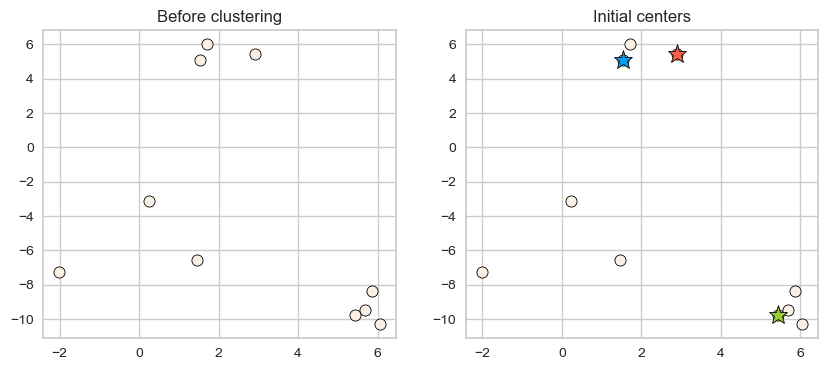

In [16]:
np.random.seed(seed=3)
centers_idx = np.random.choice(range(0, n_examples), size=k)
centers = X[centers_idx]
plot_km_initialization(X, centers) # user-defined plotting function defined in code/plotting_functions.py

**Iterative process**

repeat 

- Assign each example to the closest center. (`update_Z`)
- Estimate new centers as _average_ of observations in a cluster. (`update_centers`)

until **centers stop changing** or **maximum iterations have reached**.

- First step in the iterative process is assigning examples to the closest center. How to find closest centers? 
- Let's consider distance of an example to all centers and assign that example to the closest center.  


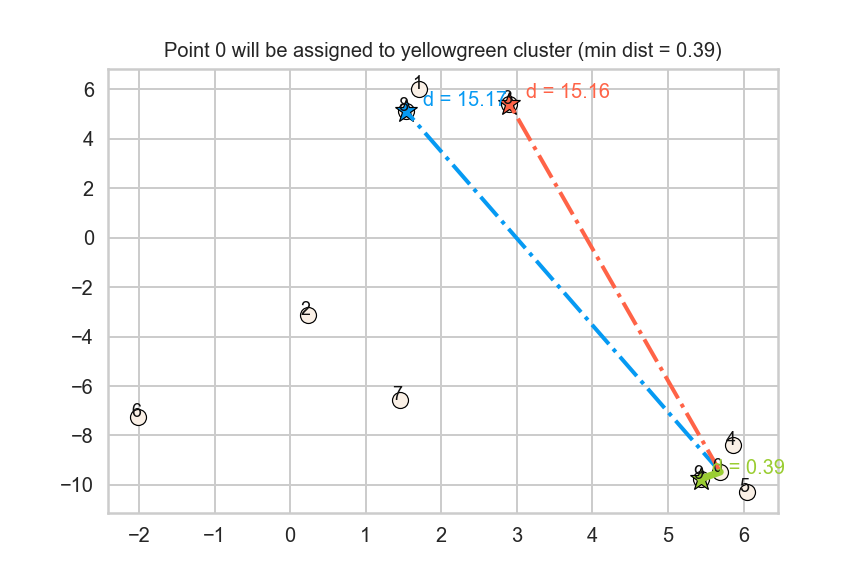
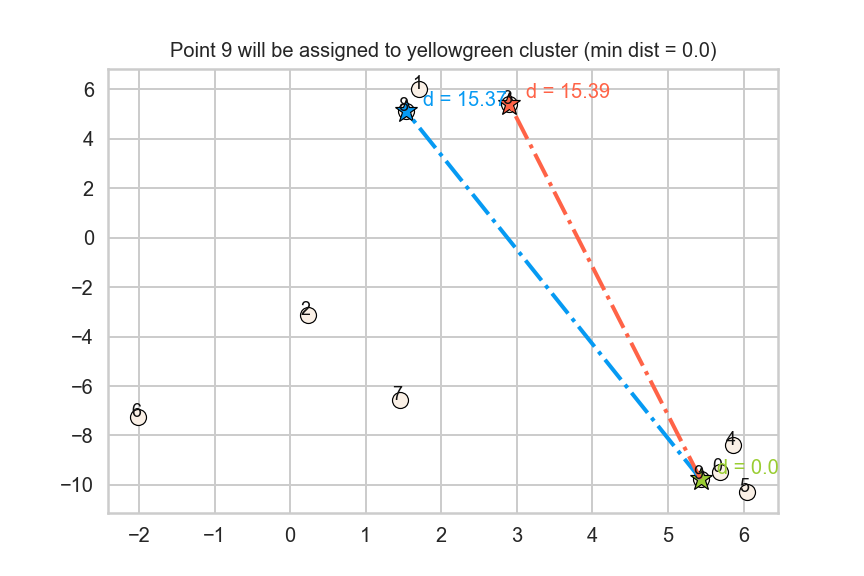
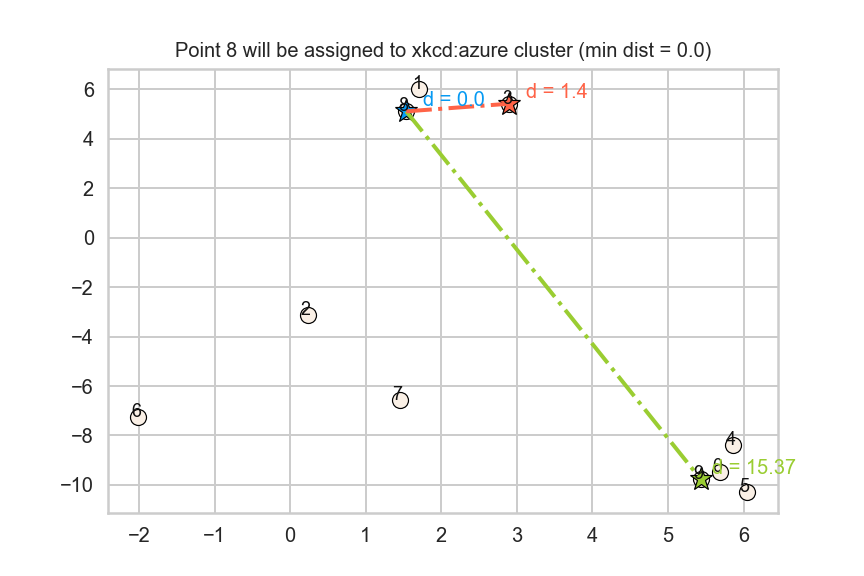
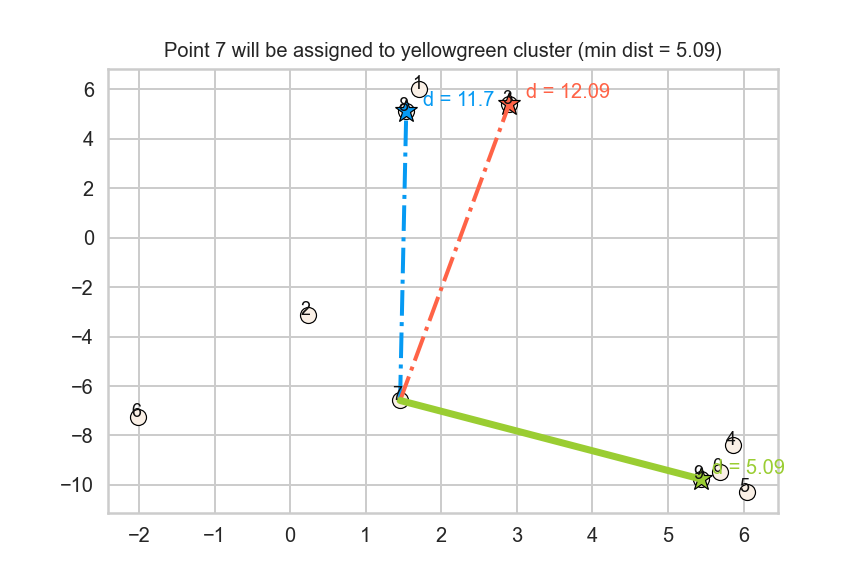
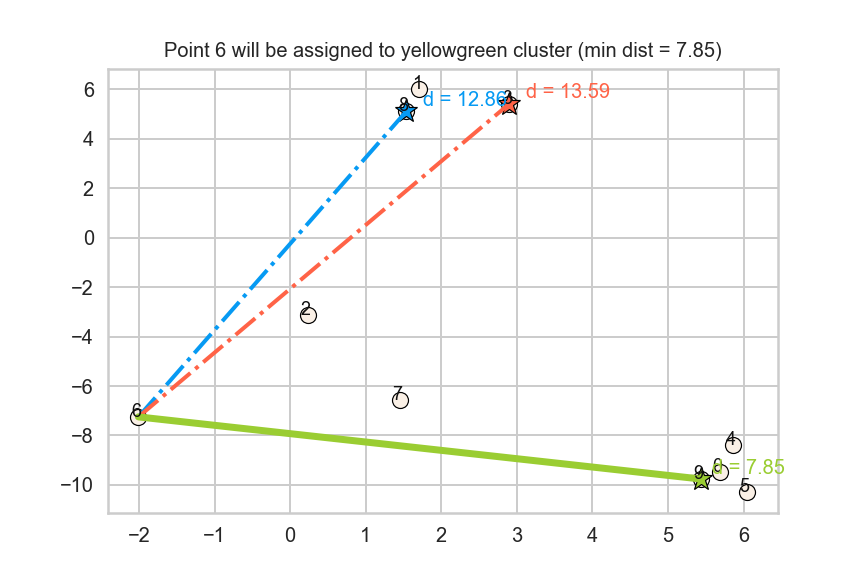
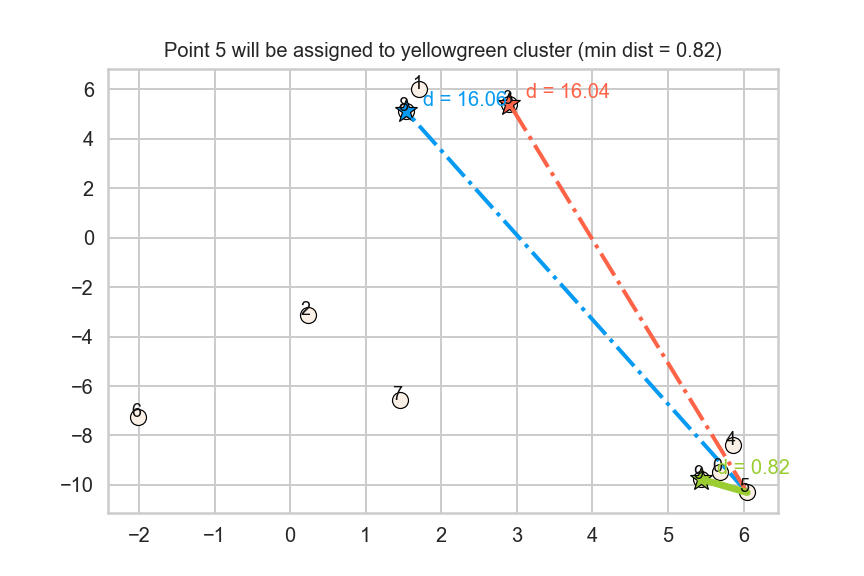
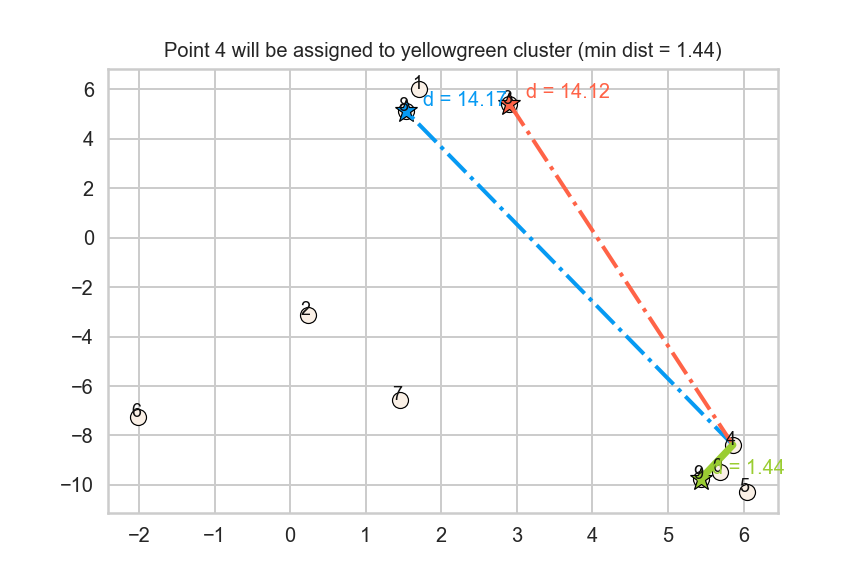
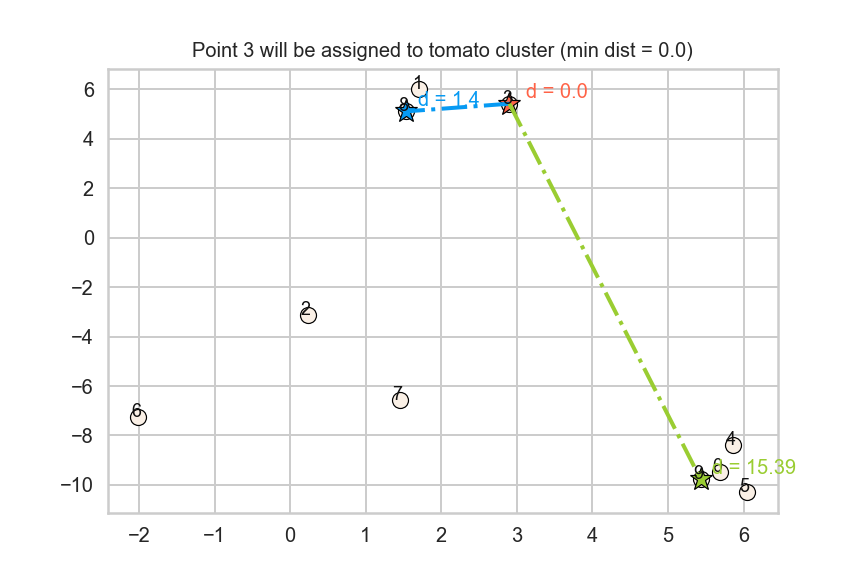
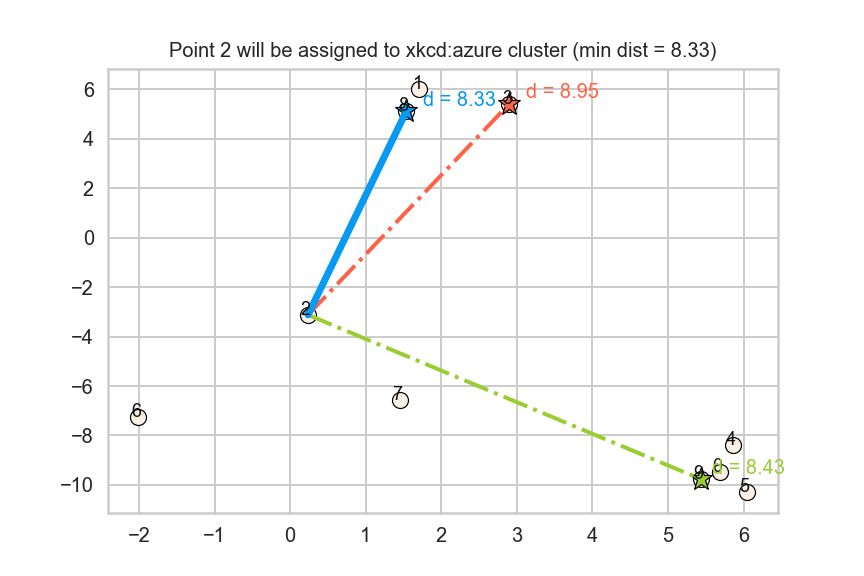
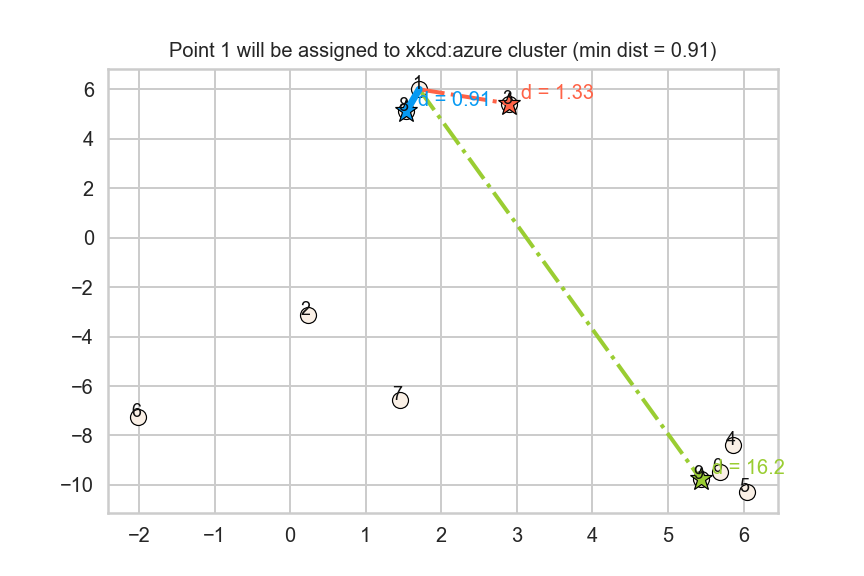
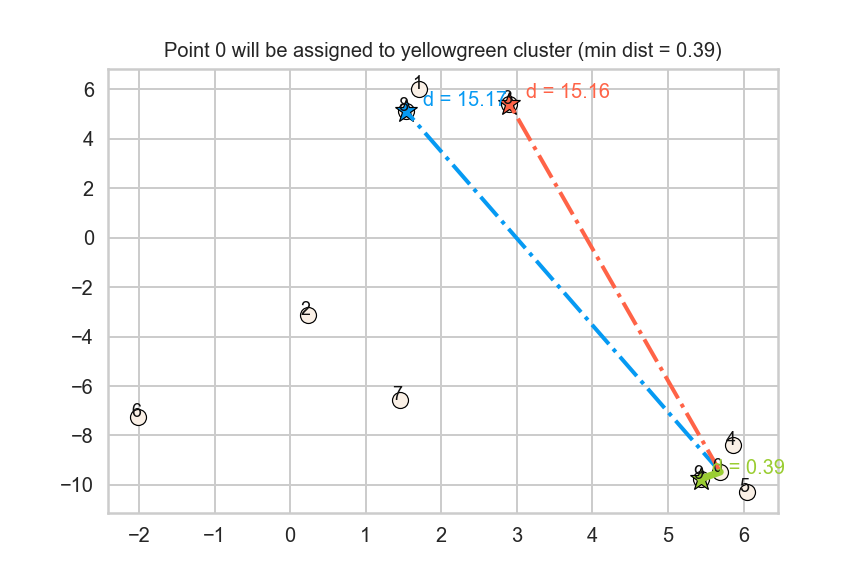

In [17]:
import panel as pn
from panel import widgets
from panel.interact import interact
import matplotlib.pyplot as plt

pn.extension()

def f(point_index):
    fig = plt.figure(figsize=(6, 4))
    # user-defined plotting function defined in code/plotting_functions.py
    return plot_example_dist(X, centers, fig, point_ind=point_index)
    
interact(f, point_index=widgets.FloatSlider(start=0, end=9, step=1, value=0)).embed(max_opts=9)
# interact(f, point_index=widgets.FloatSlider(start=0, end=9, step=1, value=0))

- Similarly, we can make cluster assignments for all points by calculating distances of all examples to the centers and assigning it to the cluster with smallest distance.  

In [18]:
from sklearn.metrics import euclidean_distances

def update_Z(X, centers):
    """
    returns distances and updated cluster assignments
    """
    dist = euclidean_distances(X, centers)
    return dist, np.argmin(dist, axis=1)

- With the new cluster assignments for our data points, we update cluster centers. How do we update centers? 
- New cluster centers are means of data points in each cluster. 

In [19]:
def update_centers(X, Z, old_centers, k):
    """
    returns new centers
    """
    new_centers = old_centers.copy()
    for kk in range(k):
        new_centers[kk] = np.mean(X[Z == kk], axis=0)
    return new_centers

Let's put these steps together. 
- Initialize
- Iteratively alternate between the following two steps.
    - **Update assignments** $Z \rightarrow$ Assign each example to the closest center
    - **Update centers** $\rightarrow$ Estimate new centers as _average_ of examples in a cluster

Let's examine the initial centers. 

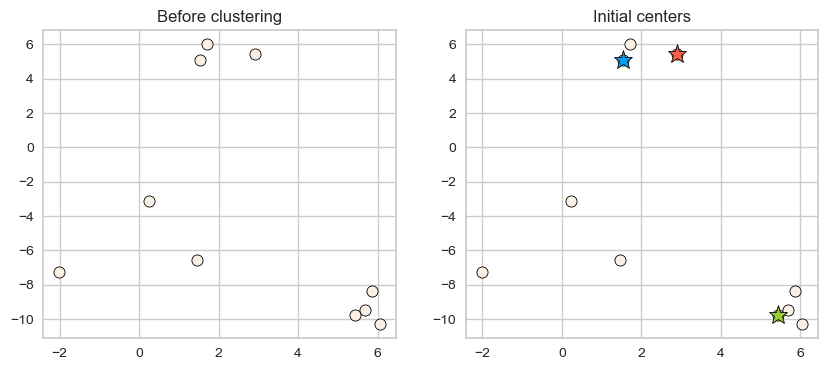

In [20]:
plot_km_initialization(X, centers)

Now let's examine how the assignments and centers change in our toy example.  


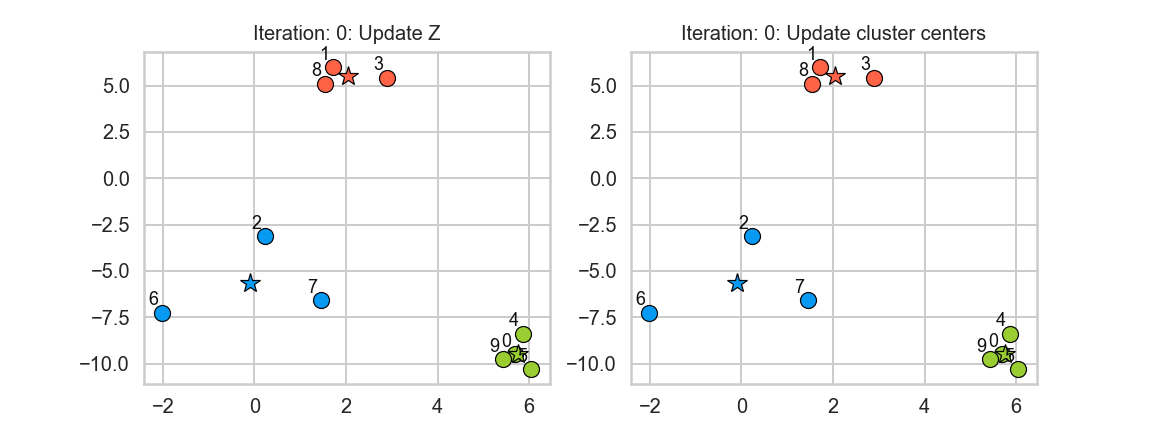
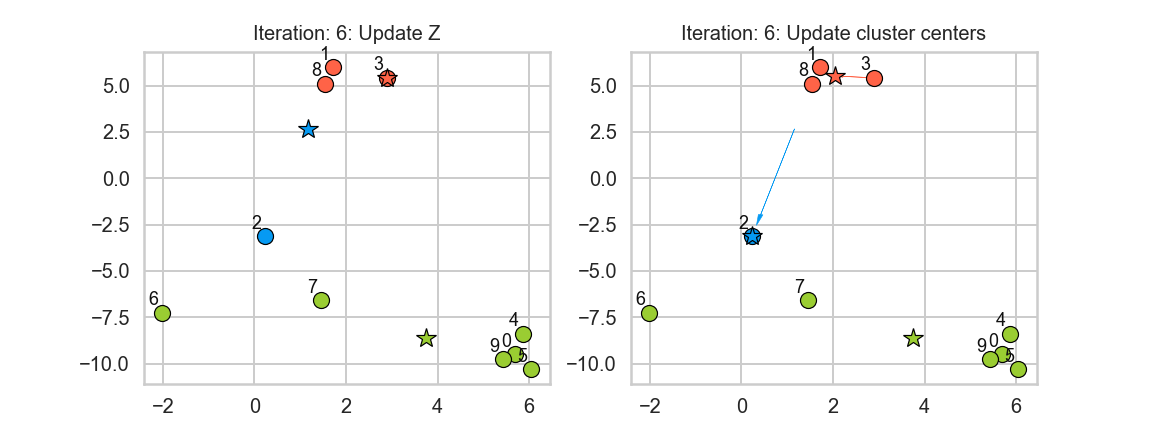
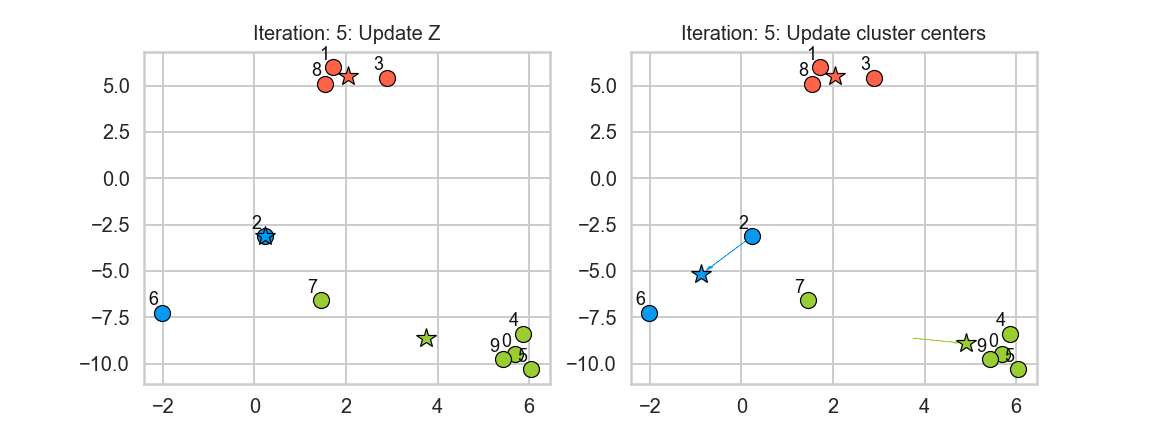
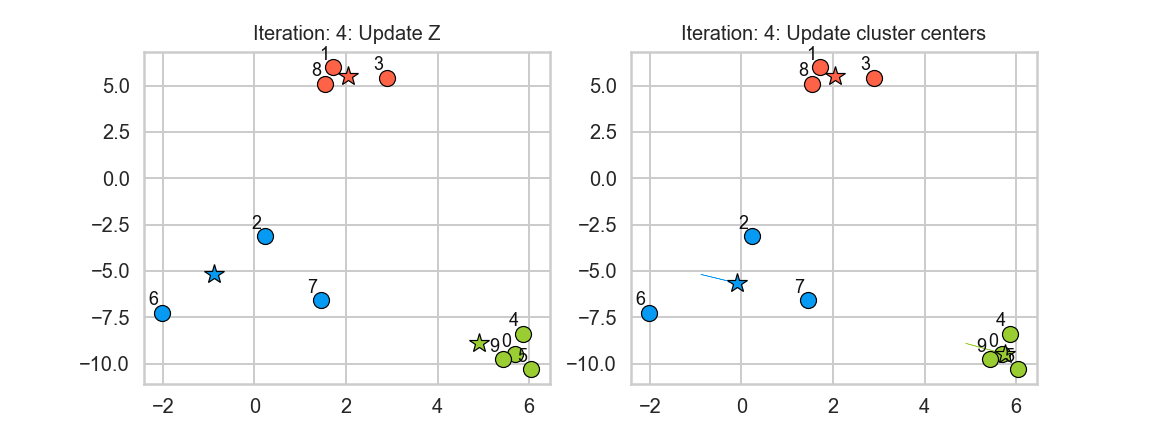
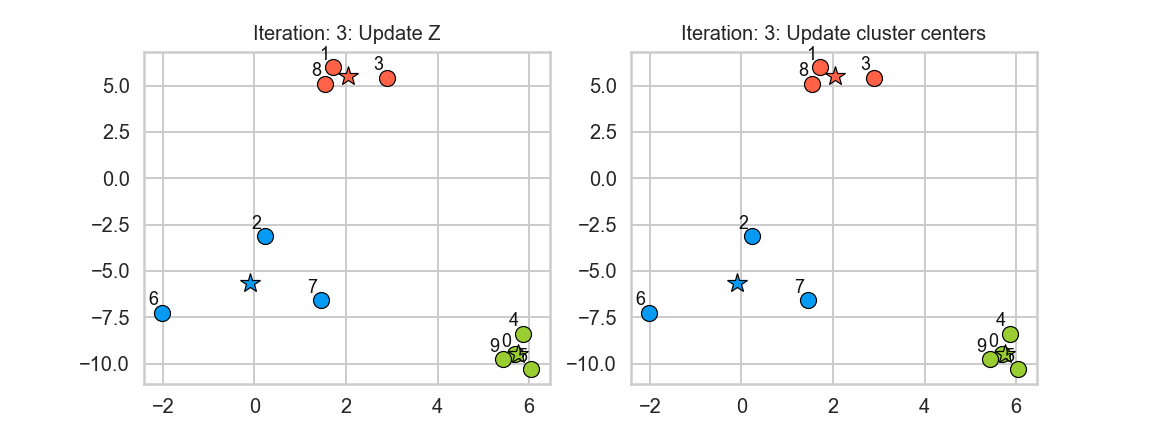
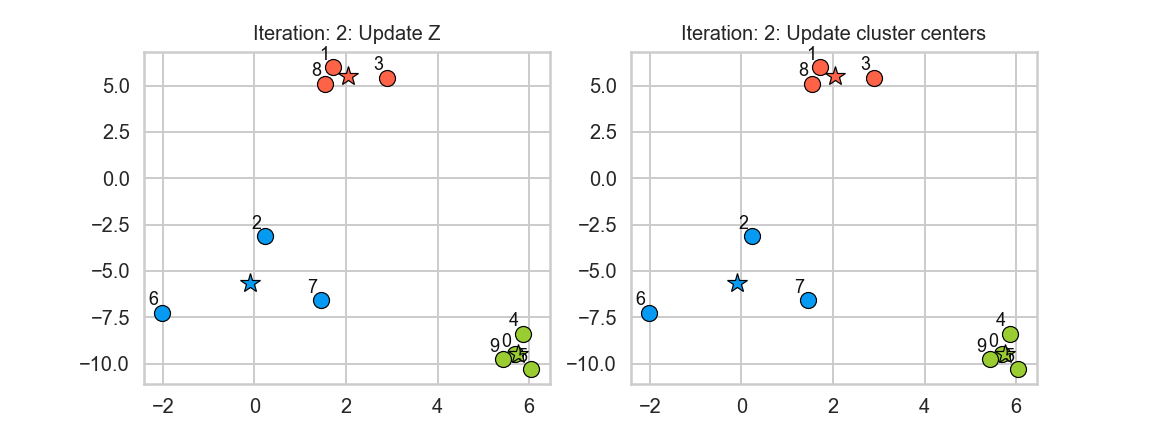
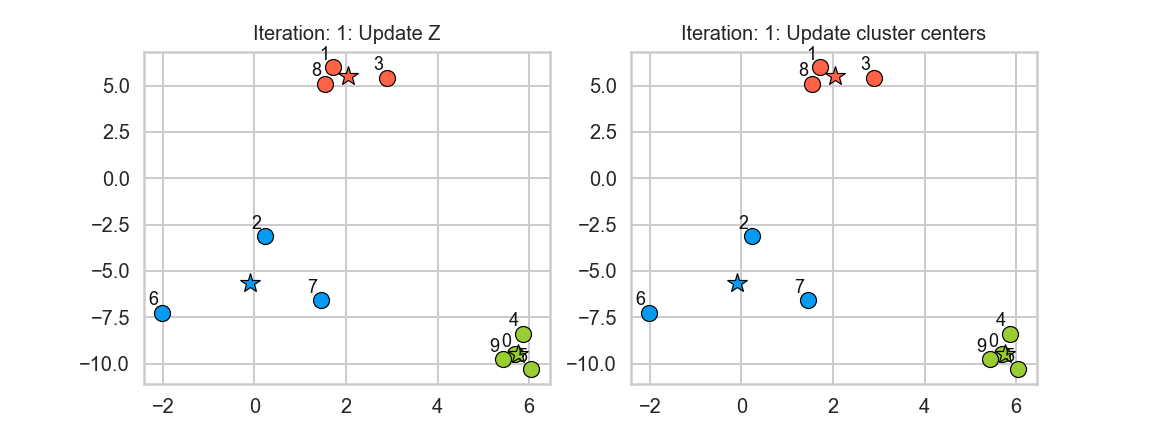
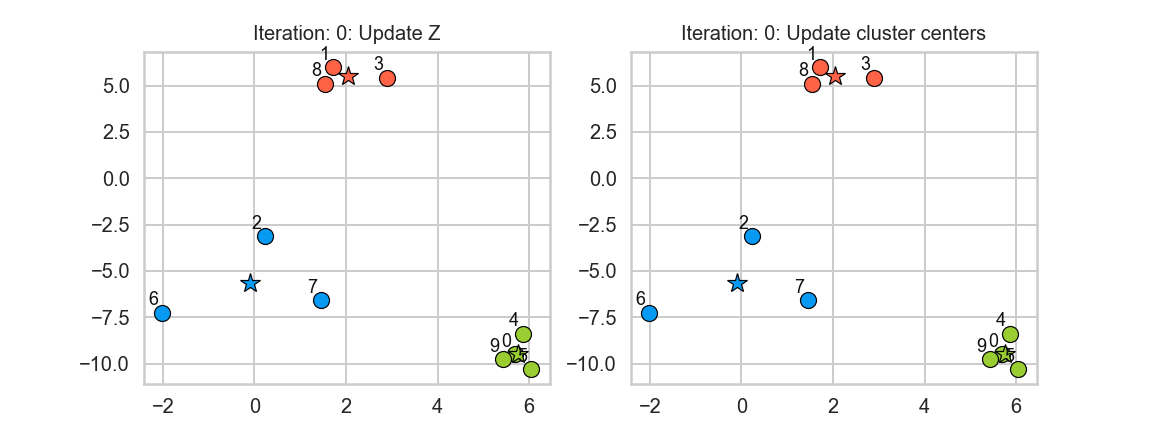

In [21]:
new_centers = X[centers_idx]  
centers = X[centers_idx]

def f(iteration):
    global centers, new_centers
    centers = new_centers.copy()
    dist, Z_km = update_Z(X, centers)    
    new_centers = update_centers(X, Z_km, centers, k)
    fig, ax = plt.subplots(1, 2, figsize=(8, 3)) 
    # user-defined plotting function defined in code/plotting_functions.py
    return plot_km_iteration(X, Z_km, centers, new_centers, iteration, fig, ax)

interact(f, iteration=widgets.FloatSlider(start=0, end=6, step=1, value=0)).embed(max_opts=11)
# interact(f, iteration=widgets.FloatSlider(start=0, end=6, step=1, value=0))

- Seems like after iteration 4 our centroids aren't changing anymore. 
- **The algorithm has converged.** So we stop! 
- K-Means always converges. It doesn't mean it finds the "right" clusters. It can converge to a sub-optimal solution.   

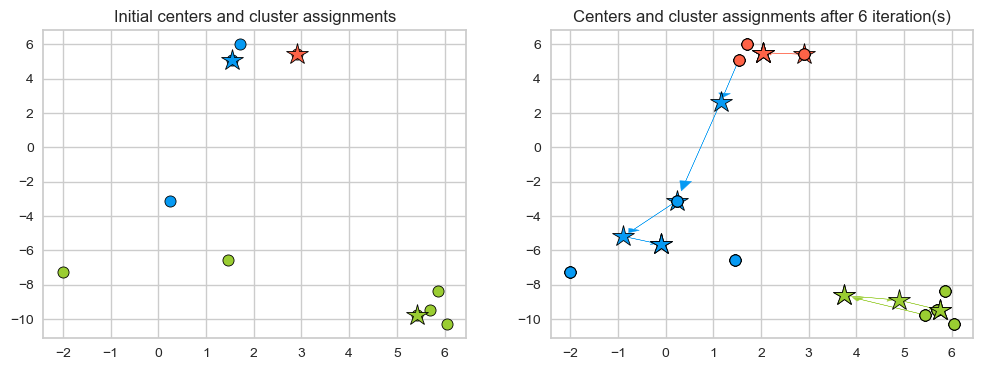

In [22]:
plot_km_iterative(X, X[centers_idx], 6) # user-defined plotting function defined in code/plotting_functions.py

<br><br><br>

### 2.4 Initialization of K-Means

- The initialization of K-Means is stochastic, can this affect the results?
    - Yes! Big time.  
- Let's look at an example. 

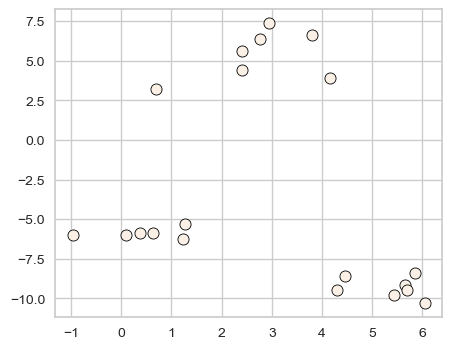

In [23]:
X_init, y_init = make_blobs(n_samples=20, centers=3, n_features=2, random_state=10)
discrete_scatter(X_init[:, 0], X_init[:, 1], markers="o");

In [24]:
k = 3
n_examples = X_init.shape[0]

**Example: Bad initialization**

In [25]:
np.random.seed(seed=10)
centroids_idx_init = np.random.choice(range(0, n_examples), size=k)
centroids = X_init[centroids_idx_init]

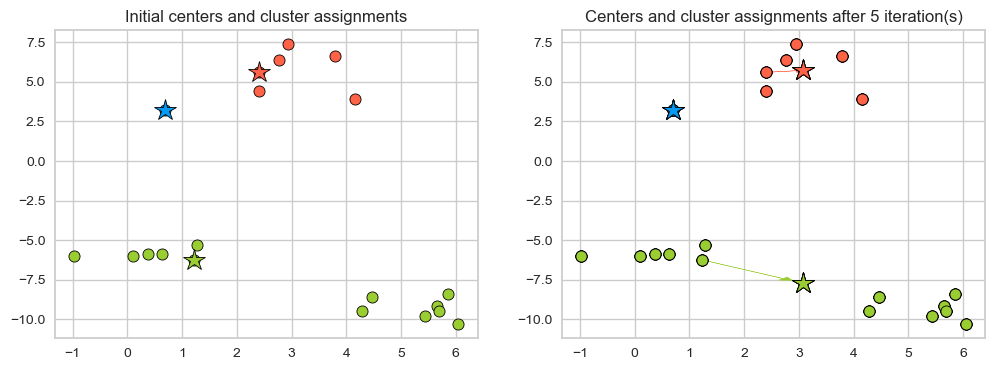

In [26]:
plot_km_iterative(X_init, X_init[centroids_idx_init], 5)

**Example: Better initialization**
The following initialization seems much better. 

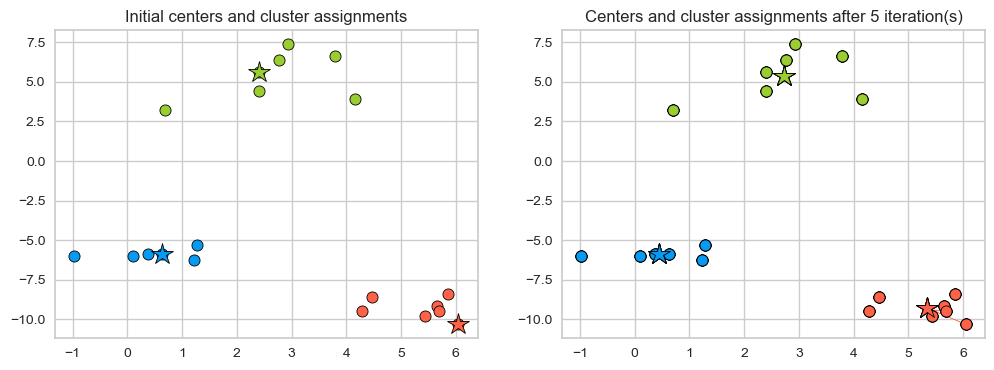

In [27]:
np.random.seed(seed=2)
centroids_idx = np.random.choice(range(0, n_examples), size=k)
plot_km_iterative(X_init, X_init[centroids_idx], 5)

**What can we do about it?**

- One strategy is to run the algorithm several times. 
    - Check out `n_init` parameter of [`sklearn`'s `KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). 
- Is it possible to pick `K` in a smart way? 
    - Yes! We can use the so-called [K-Means++](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf).
    - Intuitively, it picks the initial centroids which are far away from each other. 
    - In other words, K-Means++ gives more chance to select points that are far away from centroids already picked.    
    - By default `sklearn` uses this strategy for initialization. 

<br><br><br><br>

### (Optional) 2.5 

**(Optional) Objective function for K-Means**

- Find the local minimum of minimizing squared distances (L2 norm).  
- The algorithm optimizes the sum of the distances of the cluster centers to all the points in that cluster. In other words, it minimizes within-cluster sum-of-squares criterion. 

$$\sum_{i=1}^k\sum_{j=1}^n u_{ij}\lVert{\mathbf{x}_j-\mathbf{c}_i}\rVert^2_2$$

- $u_{ij}$ is 1 if the point $\mathbf{x}_j$ belongs to cluster $i$, and 0 otherwise
- $\mathbf{c}_i$ is the centroid of the $i^{th}$ cluster

- It's an NP hard problem and we cannot hope to solve it exactly but the K-Means algorithm we saw provides us a local minimum.  

The algorithm above is called **Lloyd's algorithm**. More details [here](https://scikit-learn.org/stable/modules/clustering.html#k-means). 

**(Optional) Why not use gradient descent?**

- The partition matrix ${\mathbf{U}}=[u]_{ij}$ is discrete, so we cannot use gradients to help us minimize;

- Hence, the iterative approach:
    1. Obtain the centroid
    2. Change the partition

**(Optional) Distances in K-Means**

- We are using the L2 norm here to calculate distances. $$\lVert{\mathbf{x}_j-\mathbf{c}_i}\rVert^2_2$$ 
- We can use a different distance metrics; but then, 
    - it won't be K-Means anymore, as the very idea of mean is based on Euclidean distance. 
- K-Means can be thought as a special case of the expectation maximization algorithm. 

**(Optional) Feature engineering using K-Means**

- K-Means could be used for feature engineering in supervised learning. 
- Examples: 
    - You could add a categorical feature: cluster membership
    - You could add a continuous features: distance from each cluster center
- See [this paper](http://ai.stanford.edu/~acoates/papers/coatesleeng_aistats_2011.pdf).

**(Optional) Time complexity of K-Means**

- Naive implementation of K-Means requires you to compute the distances from all data points to all cluster centers. 
- So there are many distance calculations per iteration. 
- calculating assigning observations to centers is heavy: $\mathcal{O(ndk)}$
- updating centers is light(er): $\mathcal{O(nd)}$

where, 

- $n \rightarrow$ number of examples
- $d \rightarrow$ number of features
- $k \rightarrow$ number of clusters

- There are more efficient exact algorithms. 
    - Elkan's (implemented in `scikit-learn`)
    - Ying-Yang
- Here, the meaning of exact is that they give you exactly the same result as the Lloyd's algorithm but do that more efficiently.      
- Also, other approximate algorithms are being developed. 

<br><br><br><br>

### ❓❓ Questions for you

### 1.1 Select all of the following statements which are **True** (iClicker)
**iClicker cloud join link: https://join.iclicker.com/NGJD**

- (A) K-Means algorithm always converges to the same solution.
- (B) $K$ in K-Means should always be $\leq$ # of features.
- (C) In K-Means, it makes sense to have $K$ $\leq$ # of examples. 
- (D) In K-Means, in some iterations some points may be left unassigned. 

```{admonition} V's Solutions!
:class: tip, dropdown
- C
```

<br><br><br><br>

### 1.2 Select all of the following statements which are **True** (iClicker)
**iClicker cloud join link: https://join.iclicker.com/NGJD**

- (A) K-Means is sensitive to initialization and the solution may change depending upon the initialization. 
- (B) K-means terminates when the number of clusters does not increase between iterations.
- (C) K-means terminates when the centroid locations do not change between iterations.
- (D) K-Means is guaranteed to find the optimal solution. 


```{admonition} V's Solutions!
:class: tip, dropdown
- A, C
```

<br><br><br><br>

## 3. Choosing K [[video](https://youtu.be/M5ilrhcL0oY)]


Suppose you are presented with the following choices for hummus, which one would you pick? 
- (A) Original hummus
- (B) Roasted garlic hummus
- (C) Lemon hummus
- (D) None

![](img/hummus.png)

- When running K-Means we need to decide the number of clusters in advance (`n_clusters` in `sklearn`). How do we pick this hyperparameter?
- In supervised setting we carried out hyperparameter optimization based on cross-validation scores. 
- Since in unsupervised learning we do not have the target values, it becomes difficult to objectively measure the effectiveness of the algorithms.
- There is no definitive or satisfactory approach.
- However, some strategies might be useful to help you determine K. 

### Method 1: The Elbow method

- This method looks at the sum of **intra-cluster distances**, which is also referred to as **inertia**. 
- The intra-cluster distance in our toy example above is given as   

$$\sum_{P_i \in C_1}  distance(P_i, C_1)^2 + \sum_{P_i \in C_2}  distance(P_i, C_2)^2 + \sum_{P_i \in C_3} distance(P_i, C_3)^2$$

Where 
- $C_1, C_2, C_3$ are centroids 
- $P_i$s are points within that cluster
- $distance$ is the usual Euclidean distance. 

### Inertia 

You can access this intra-cluster distance or inertia as follows. 

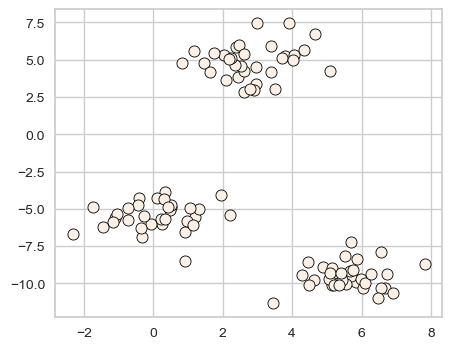

In [28]:
XX, y = make_blobs(centers=3, n_features=2, random_state=10)
discrete_scatter(XX[:, 0], XX[:, 1], markers="o");

In [29]:
d = {"K": [], "inertia": []}
for k in range(1, 100, 10):
    model = KMeans(n_clusters=k, n_init='auto').fit(XX)
    d["K"].append(k)
    d["inertia"].append(model.inertia_)

In [30]:
pd.DataFrame(d)

,K,inertia
0,1,4372.460950
1,11,70.076284
2,21,26.137410
3,31,15.359887
4,41,6.844921
5,51,3.593508
6,61,2.126488
7,71,1.016676
8,81,0.385639
9,91,0.053156


- The inertia decreases as K increases. 
- Question: Do we want inertia to be small or large? 
- The problem is that we can't just look for a $k$ that minimizes inertia because it decreases as $k$ increases.
    - If I have number of clusters = number of examples, each example will have its own cluster and the intra-cluster distance will be 0.  
- Instead we evaluate the trade-off: "small k" vs "small intra-cluster distances". 

In [31]:
def plot_elbow(w, h, inertia_values):
    plt.figure(figsize=(w, h))
    plt.axvline(x=3, linestyle="-.", c="black")
    plt.plot(range(1, 10), inertia_values, "-o")
    ax = plt.gca()
    ax.tick_params("both", labelsize=(w + h))
    ax.set_xlabel("K", fontsize=w+h)
    ax.set_ylabel("Inertia", fontsize=w+h)

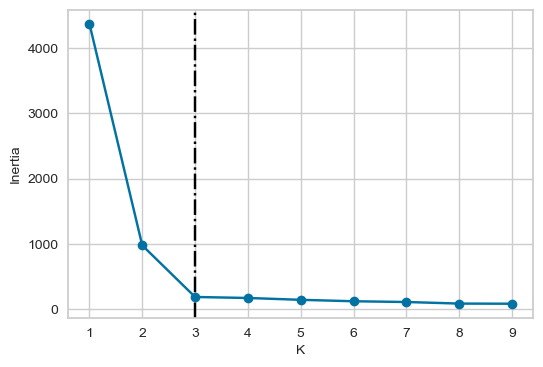

In [32]:
inertia_values = list()
for k in range(1, 10):
    inertia_values.append(KMeans(n_clusters=k, n_init='auto').fit(XX).inertia_)
plot_elbow(6, 4, inertia_values)

- From the above plot, we could argue that three clusters (the point of inflection on the curve) are enough.
- The inertia decreases when clusters are greater than 3. However it's not a big improvement and so we prefer K=3. 
- In this toy example, it's the plot is kind of clear and easy to interpret but it can be hard to interpret in real life examples. 

There is a package called [`yellowbrick`](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html) which can be used to create these plots conveniently. 

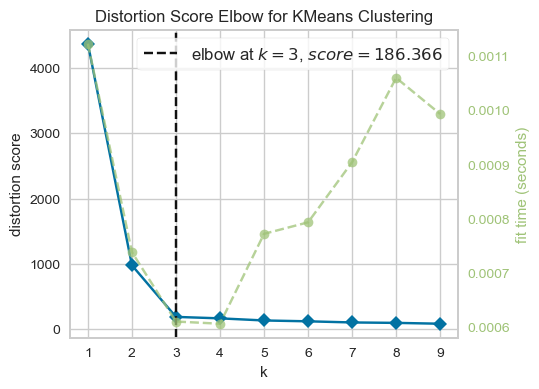

In [33]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(n_init='auto')
visualizer = KElbowVisualizer(model, k=(1, 10))

visualizer.fit(XX)  # Fit the data to the visualizer
visualizer.show();

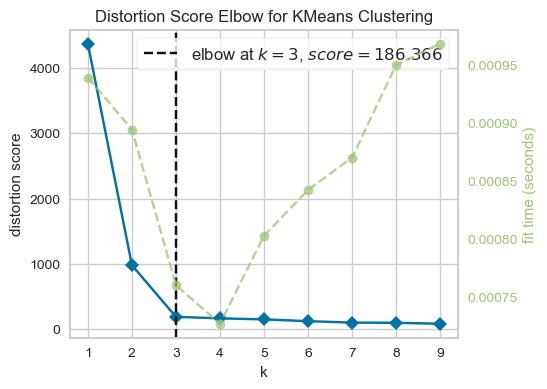

In [34]:
visualizer = KElbowVisualizer(model, k=(1, 10))

visualizer.fit(XX)  # Fit the data to the visualizer
visualizer.finalize();

<br><br>

### Method 2: The Silhouette method

- Not dependent on the notion of cluster centers. 
- Calculated using the **mean intra-cluster distance** ($a$) and the **mean nearest-cluster distance** ($b$) for each sample.

**Mean intra-cluster distance ($a$)**

- Suppose the green point below is our sample. 
- Average of the distances of the green point to the other points in the same cluster.
  - These distances are represented by the black lines. 
  

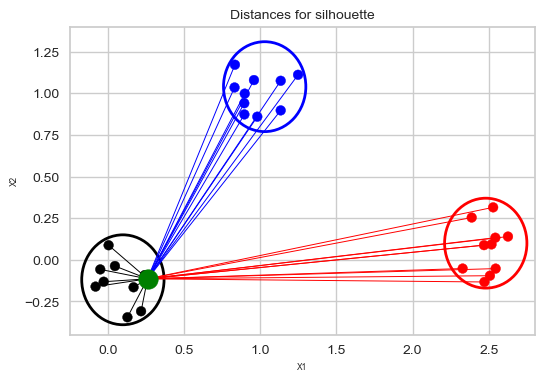

In [35]:
plot_silhouette_dist(6, 4)

**Mean nearest-cluster distance ($b$)**

- Average of the distances of the green point to the blue points is smaller than the average of the distances of the green point to the red points. So the **nearest cluster** is the blue cluster. 
- So the mean nearest-cluster distance is the average of the distances of the green point to the blue points.  

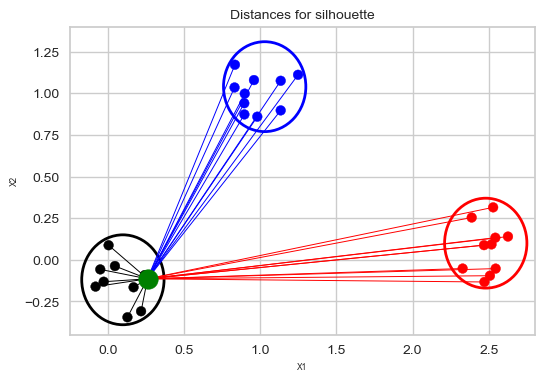

In [36]:
plot_silhouette_dist(6, 4)

**Silhouette distance for a sample**

- the difference between the **the average nearest-cluster distance** ($b$) and **average intra-cluster distance** ($a$) for each sample, normalized by the maximum value

$$\frac{b-a}{max(a,b)}$$

- The best value is 1. 
- The worst value is -1 (samples have been assigned to wrong clusters).
- Value near 0 means overlapping clusters i.e., the example is on or very close to the decision boundary between two neighbouring clusters.  

The overall **Silhouette score** is the average of the Silhouette scores for all samples. We can visualize the silhouette score for each example individually in a silhouette plot (hence the name), see below.

**Using Silhouette scores to select the number of clusters**

- The plots below show the Silhouette scores for each sample in that cluster. 

In [37]:
from yellowbrick.cluster import SilhouetteVisualizer

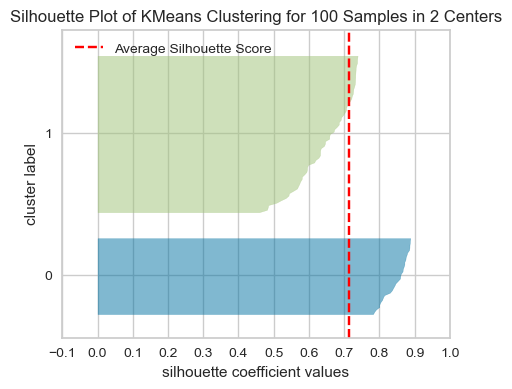

In [38]:
model = KMeans(2, n_init='auto', random_state=42)
visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
visualizer.fit(XX)  # Fit the data to the visualizer
visualizer.show();
# Finalize and render the figure

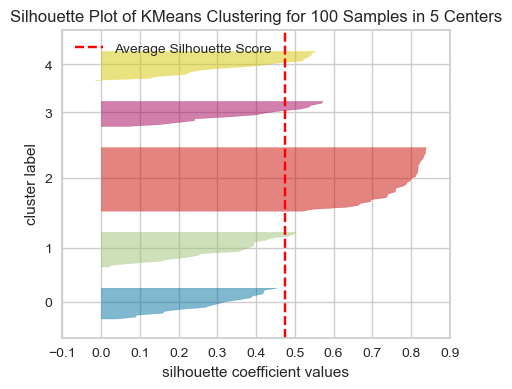

In [39]:
model = KMeans(5, n_init='auto', random_state=42)
visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
visualizer.fit(XX)  # Fit the data to the visualizer
visualizer.show();
# Finalize and render the figure

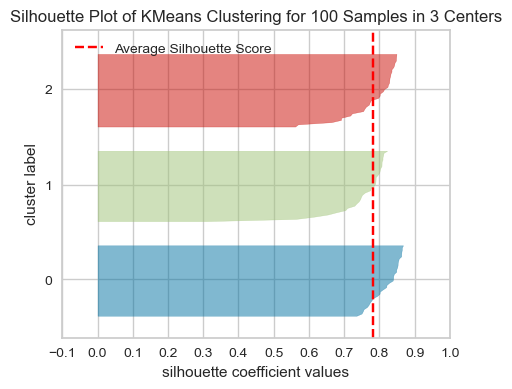

In [40]:
model = KMeans(3, n_init='auto', random_state=42)
visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
visualizer.fit(XX)  # Fit the data to the visualizer
visualizer.show();
# Finalize and render the figure

**What to look for in these plots?**

- The thickness of each silhouette represents the size of that cluster. In the above plot, our three clusters are of similar sizes.
- The length (or area) of each silhouette indicates the "goodness" of each cluster.
- A slower dropoff (more rectangular) indicates more points are "happy" in their cluster.
- The red dashed line shows the average silhouette score for all samples, which tells you the overall clustering fit. The close this score is to 1, the better the clustering fit is. In our example, the average score seems to be around 0.78, which suggests a strong cluster structure.
- For a well-fitted clustering model, you'd expect to see the silhouette plots for each cluster above the average silhouette score line, and with widths which do not vary wildly.  
- In general, if any cluster has many points below the average silhouette score, this could be a sign that the cluster is not well separated from its neighbouring cluster, or it has too much internal variance, suggesting that the number of cluster chosen might not be ideal.
- We can apply Silhouette method to clustering methods other than K-Means.

**Some limitations of these measures**

Although the Elbow plot and Silhouette plot are popular methods for determining the optimal number of clusters, it's important to use them with a grain of salt due to their limitations, which include:

- The subjectivity in identifying the "elbow" point, which is not always clear-cut.
- A focus on variance reduction without directly measuring the quality of the clustering.
- Challenges in interpreting the overall clustering quality in cases where clusters have a mix of positive and negative silhouette values.
- The potential inability of silhouette plots to effectively capture the performance of the clustering algorithm in datasets with complex shapes or varying densities.
  
**Remember, the primary purpose of clustering is to improve human understanding of data.** So, when working with clustering, you are likely to spend a considerable amount of time manually interpreting clusters and conducting qualitative analysis to identify themes within the data. While methods like the Elbow Plot and Silhouette Plot provide quantitative measures to guide the clustering process, integrating these quantitative assessments with qualitative analysis is crucial for effective clustering in exploratory data analysis.

<br><br><br><br>

### ❓❓ Questions for you

### 1.3 Select all of the following statements which are **True** (iClicker)
**iClicker cloud join link: https://join.iclicker.com/NGJD**

- (A) If you train K-Means with `n_clusters`= the number of examples, the inertia value will be 0. 
- (B) The elbow plot shows the tradeoff between within cluster distance and the number of clusters.
- (C) Unlike the Elbow method, the Silhouette method is not dependent on the notion of cluster centers.
- (D) The elbow plot is not a reliable method to obtain the optimal number of clusters in all cases. 
- (E) The Silhouette scores ranges between -1 and 1 where higher scores indicates better cluster assignments.

```{admonition} V's Solutions!
:class: tip, dropdown
- A, B, C, D, E
```

<br><br><br><br>

## 4. Introduction to Gaussian mixture models (high-level)

### 4.1 Motivation

- K-Means is great but it cannot handle oddly shaped clusters. 
- In K-Means our clusters are solely defined by cluster centers.
- Let's look at a toy example.

In [41]:
from scipy.stats import multivariate_normal, norm
from sklearn.datasets import make_blobs, make_circles, make_moons

dataset_sub1 = multivariate_normal.rvs(
    mean=[2, 4], cov=[[12, 11.5], [11.5, 12]], size=200, random_state=42
)

dataset_sub2 = multivariate_normal.rvs(
    mean=[11, -3], cov=[[12, -10], [-10, 12]], size=100, random_state=42
)

dataset_sub3,y = make_blobs(random_state=42, centers =1, cluster_std=1.8, n_samples=50)
dataset_sub4 = dataset_sub3 + np.array([4, -14])

X_train = np.vstack([dataset_sub1, dataset_sub2, dataset_sub4])
# X_train = np.vstack([dataset_sub1, dataset_sub2])

X_train.shape

(350, 2)

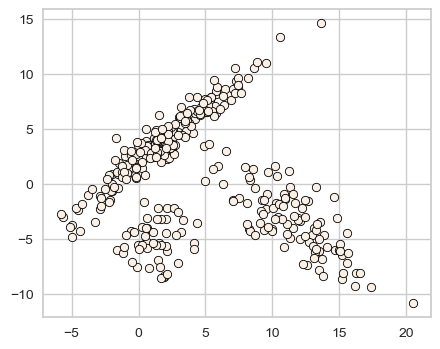

In [42]:
discrete_scatter(X_train[:,0], X_train[:,1],s=6);

How well KMeans clusters this data? 

In [43]:
km = KMeans(n_clusters=3, n_init="auto")
km.fit(X_train)

KMeans(n_clusters=3)

In [44]:
km_labels = km.labels_

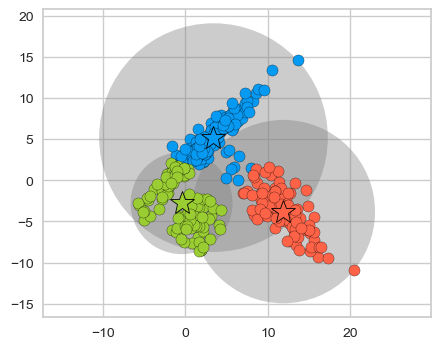

In [45]:
plot_kmeans_circles(km, X_train, n_clusters=3)

- K-Means is not doing a good job. 
- One limitation of K-Means is that it only takes into account means of data points and not the spread of the data points. 
- How about taking into account the covariance matrices, i.e., how spread out the data is?
- Is it possible to generalize K-Means clustering to incorporate information about the covariance structure of the data as well as the centers? 
- One idea is to model the data as a weighted sum of Gaussian distributions, where each Gausssian, referred to as a **component** of the mixture, has its own mean vector and covariance matrix and a corresponding weight. These models are referred to as **mixture of Gaussians** or **Gaussian mixture models**. 
- There is a lot to say about these models. In the interest of time, we'll keep things high level in this course. 
- First, let's try it out with sklearn. 

In [46]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, covariance_type="full") # more on covariance_type in a bit 
gmm.fit(X_train)
gmm_labels = gmm.predict(X_train)

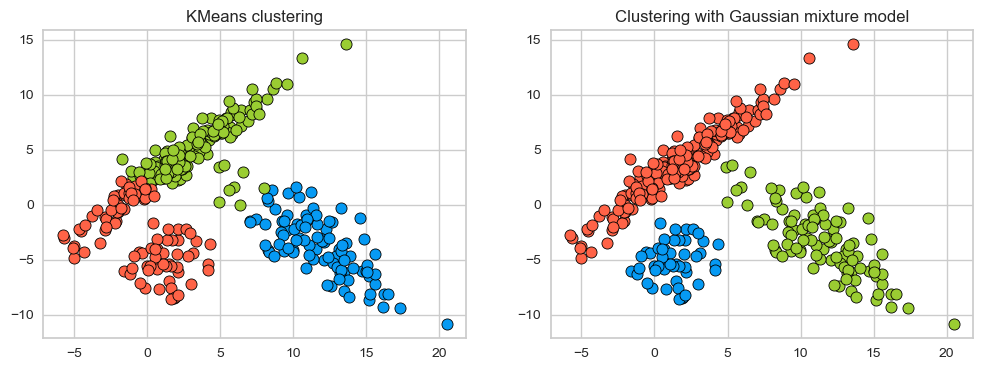

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4)) 
discrete_scatter(X_train[:, 0], X_train[:, 1], km_labels, c=gmm_labels, markers="o", ax=ax[0]);
ax[0].set_title('KMeans clustering')
discrete_scatter(X_train[:, 0], X_train[:, 1], gmm_labels, c=gmm_labels, markers="o", ax=ax[1]);
ax[1].set_title('Clustering with Gaussian mixture model');

On this toy dataset, clustering with GMM seems better; It is able to capture elipse-shaped clusters. 

Now the model is means and covariances. 

In [48]:
gmm.means_

array([[ 1.25596947, -5.15011412],
       [11.38137298, -3.31731115],
       [ 1.93609356,  3.96311554]])

Since our dataset is 2d, we get a 2d vector for the mean of each cluster.  

In [49]:
gmm.covariances_

array([[[ 1.97803583,  0.26628563],
        [ 0.26628563,  3.11174164]],

       [[ 9.09449493, -7.25892116],
        [-7.25892116,  9.394036  ]],

       [[10.95673803, 10.63462235],
        [10.63462235, 11.26072047]]])

Since our dataset is 2d, we get a 2 by 2 co-variance matrix for each cluster. 

- There is a non-negative weight associated with each component which represents the proportion of total distribution contributed by that component.  

In [50]:
gmm.weights_

array([0.14042383, 0.28682168, 0.57275449])

We have trained our model with three components so we have three weights (prior probabilities) associated with each component. The sum of the weights is 1.0. 

In [51]:
np.sum(gmm.weights_)

1.0

<br><br><br><br>

### 4.2 How does it work? (high-level)

- Given $k$, the number of clusters or the number of components, we want to fit Gaussian blobs to the data. Each Gaussian will have it's own mean vector and covariance matrix. 
- This is a **generative model**; it models the probability of a given data point being generated from the mixture of the Gaussians.  

$$P(x) = \sum_{j=1}^{k} \pi_k \mathcal{N}(x, \mu_k, \Sigma_k)$$

- $x \rightarrow$ a data point
- $\pi_k \rightarrow$ the weight of component $k$ (between 0 to 1)
- $k \rightarrow$ the number of clusters or the number of components
- $\mu_k \rightarrow$ the mean vector of component $k$
- $\Sigma_k \rightarrow$ the covariance matrix associated with component $k$

The generative story of the model assumes that each data point in the dataset is generated from one of the Gaussian components. So for each example $x$: 
- Choose component $k$ with probabilities proportional to the weight $\pi_k$ (prior probability) of the components. 
- Choose example $x$ from the Gaussian distribution associated with the $k^{th}$ component: $\mathcal{N}(x, \mu_k, \Sigma_k)$ 

How to interpret the weights associated with the Gaussians? Let's look at a toy example with of a mixture of Gaussians, i.e., a weighted sum of Gaussians. 


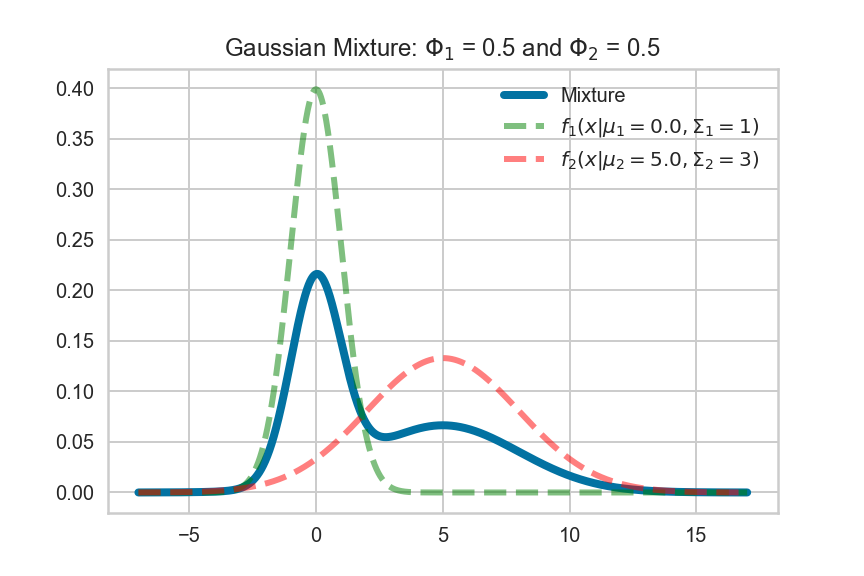
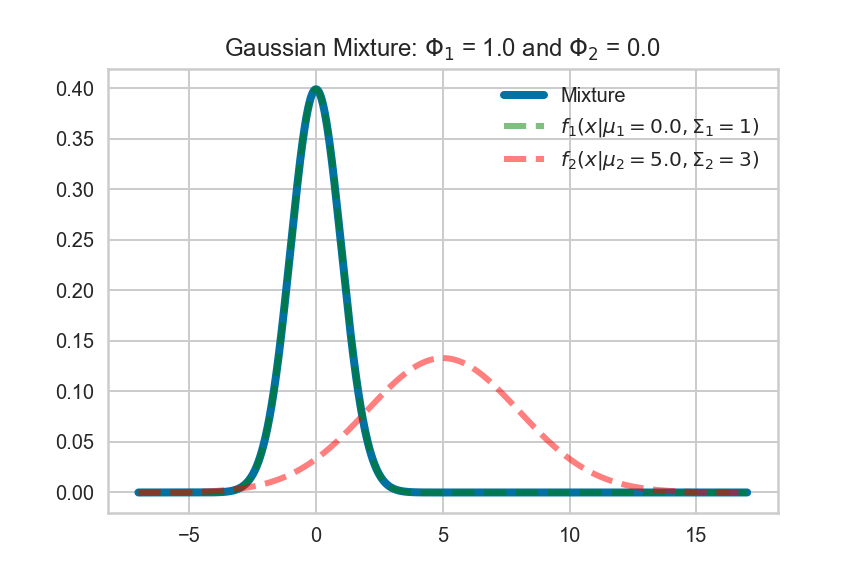
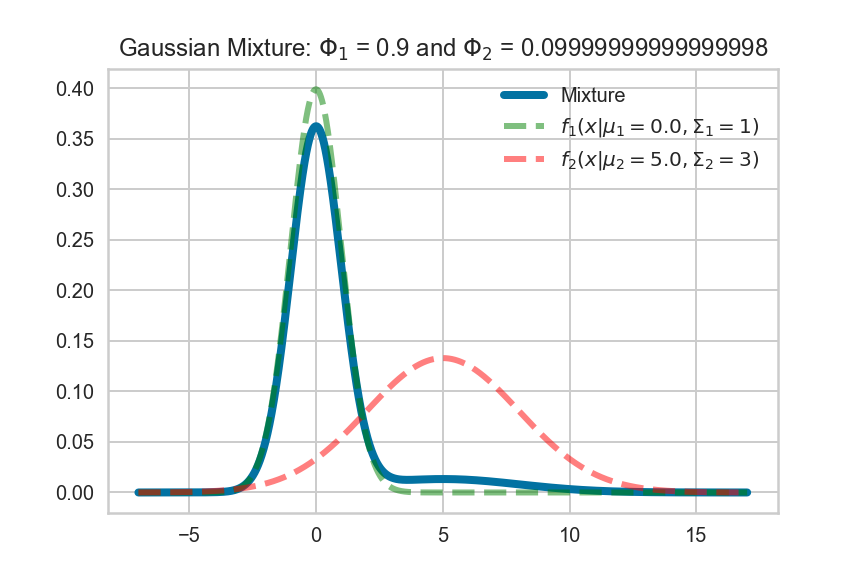
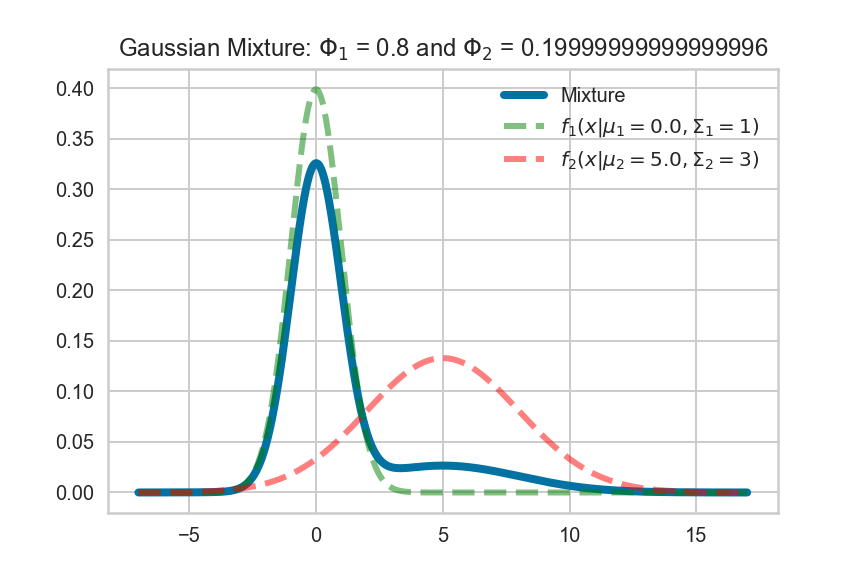
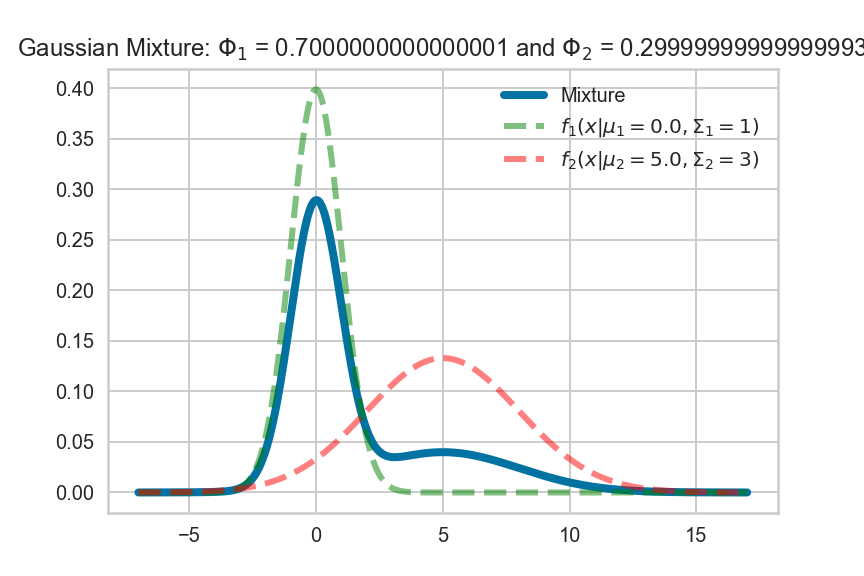
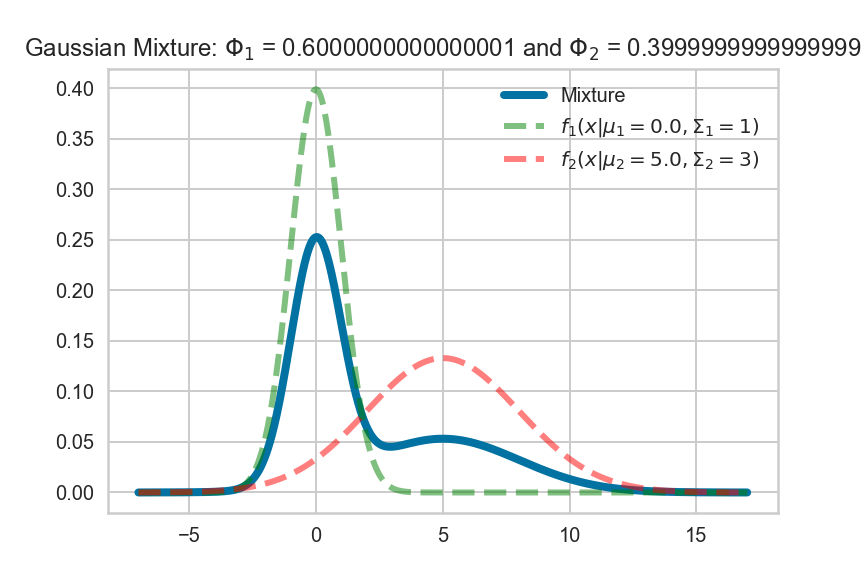
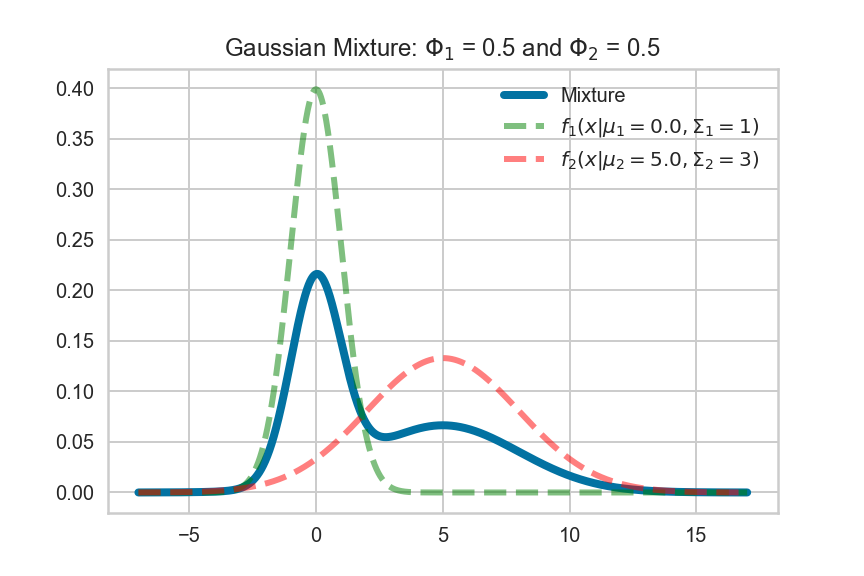
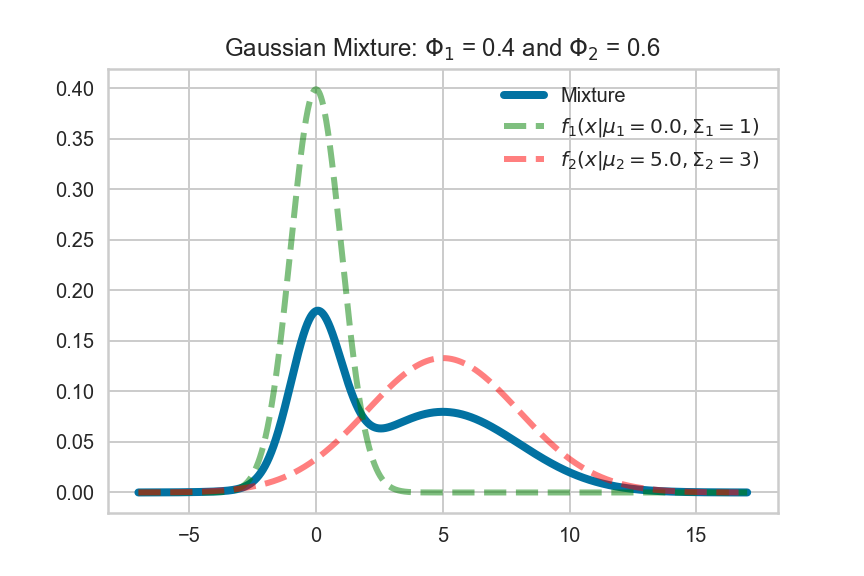
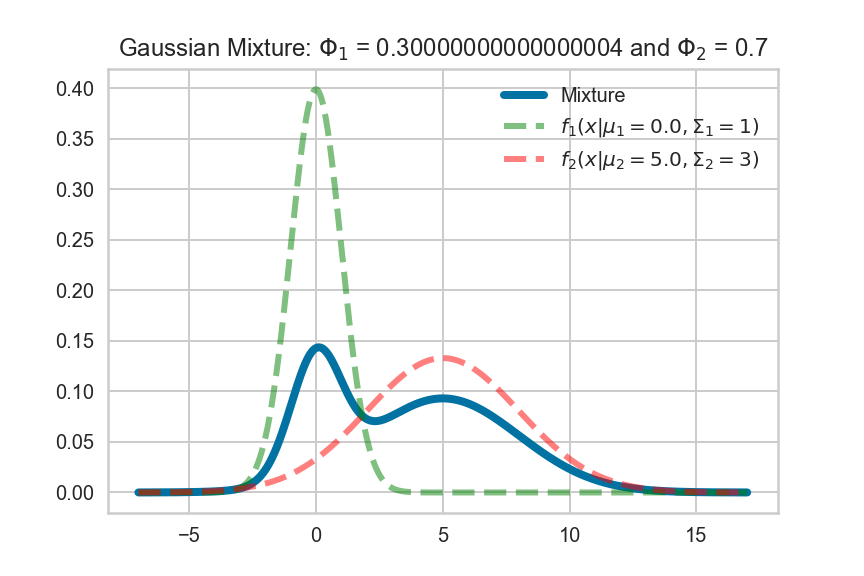
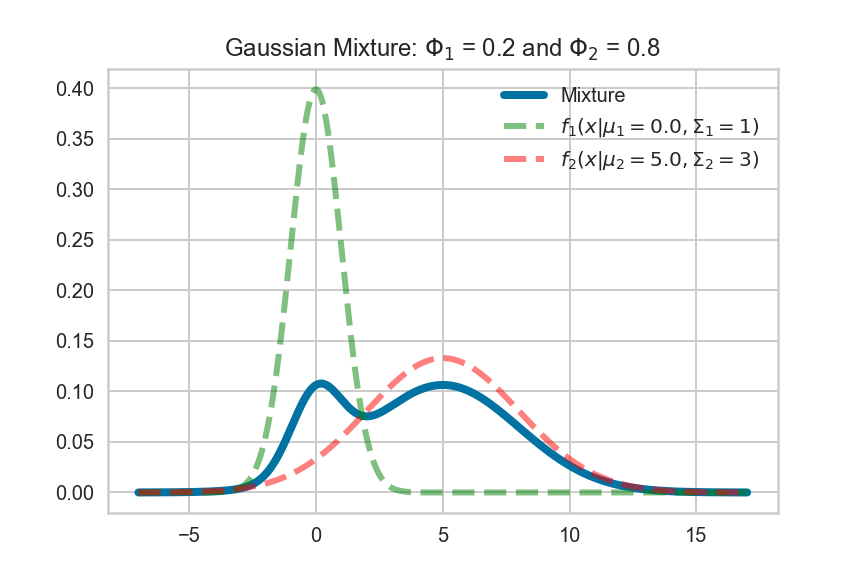
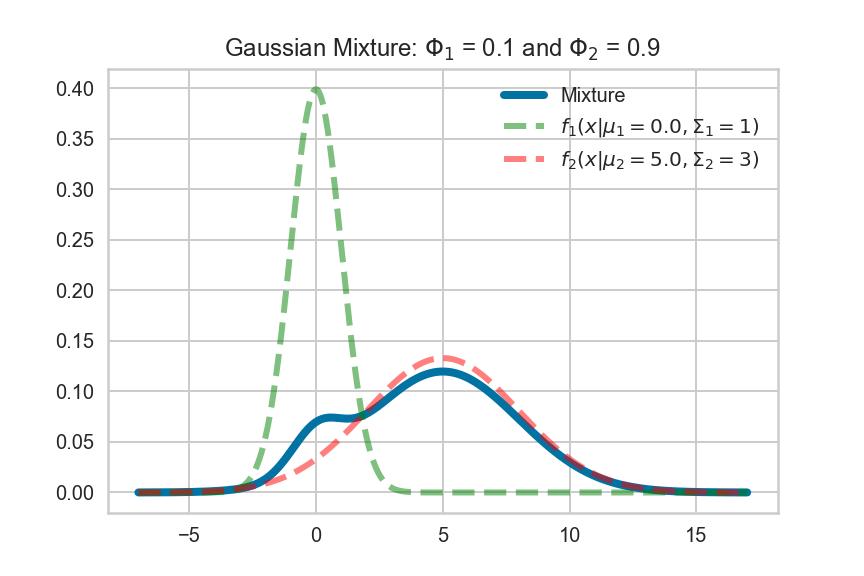
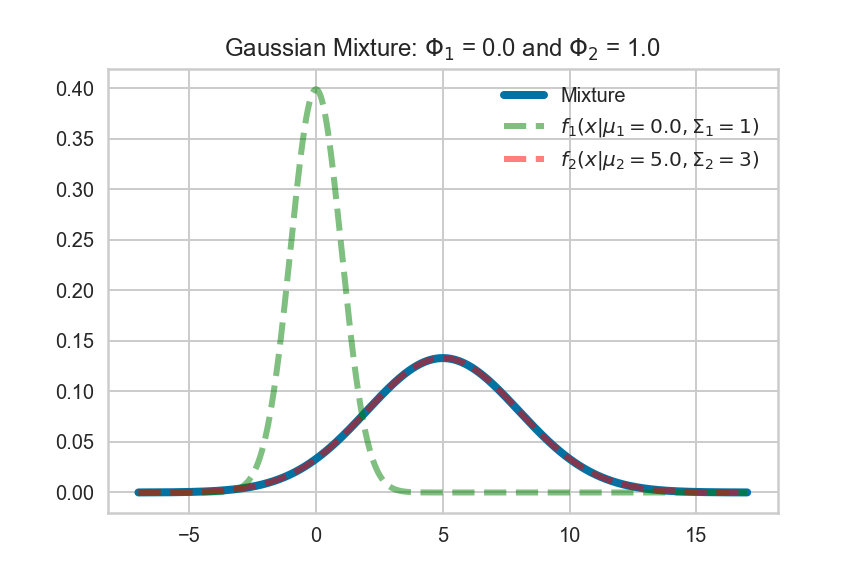

In [52]:
def f(ϕ1):
    fig = plt.figure(figsize=(6,4))        
    return Gaussian_mixture_1d(ϕ1=ϕ1, ϕ2=1-ϕ1, fig=fig)
    
interact(f, ϕ1=widgets.FloatSlider(start=0, end=1.0, step=0.1, value=0.5)).embed(max_opts=11)
#interact(f, ϕ1=widgets.FloatSlider(start=0, end=1.0, step=0.1, value=0.5))

- A mixture of Gaussians can model much more complicated shapes than a single Gaussian distribution. 

The goal is to estimate $\pi_k$, $\mu_k$, $\Sigma_k$ for all clusters or components $k$. 
- It's a non-convex optimization problem 
- It is sensitive to initialization. Usually, it's initialized with K-Means. 
- Generally used with "soft" assignments. Each point contributes to the mean and covariance of each component but the points that are far away only contribute a little.  

Under the hood it finds these parameters using an algorithm called **Expectation Maximization**. The idea is to treat the clusters as **hidden variables**. 

- Choose starting guesses for the location and shape
- Repeat until converged:
    - E-step: for each point, find weights encoding the probability of membership in each cluster
    - M-step: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights
    

We can constrain the covariance of the gaussians by using the `covariance_type` option when creating a `GaussianMixture` object. This allows us to control the shape and complexity of clusters. 

Let's look at four types supported in `sklearn`:  

In [53]:
k=3
estimators = {
    cov_type: GaussianMixture(
        n_components=k, covariance_type=cov_type, max_iter=20, random_state=0
    )
    for cov_type in ["spherical", "diag", "tied", "full"]
}

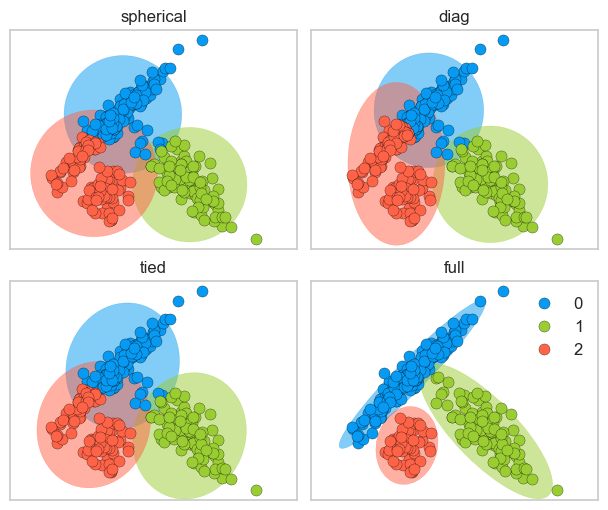

In [54]:
plot_gmm_cov_types(estimators, X_train) # user-defined function from code/plotting_functions.py

- spherical: each component has its own single variance
- diag: each component has its own diagonal covariance matrix which results in axis-aligned clusters 
- tied: all components share the same general covariance matrix which results in Gaussian components with the same shape and orientations  
- full: each component has its own general covariance matrix which results in Gaussian components with different shapes and different orientations 

Since GMMs do soft cluster assignment, we can get prediction probabilities. Below are the cluster membership probabilities for a few data points. 

In [55]:
pd.DataFrame(estimators['full'].predict_proba(X_train)[10:20]).round(4)

,0,1,2
0,0.9996,0.0000,0.0004
1,0.9899,0.0101,0.0000
2,0.9966,0.0034,0.0000
3,0.9999,0.0001,0.0000
4,0.9961,0.0039,0.0000
5,0.9935,0.0065,0.0000
6,0.9927,0.0073,0.0000
7,0.9981,0.0000,0.0019
8,0.9839,0.0157,0.0003
9,1.0000,0.0000,0.0000


**(Optional) Model selection with AIC anc BIC**

Since GMM is a generative model, we can get the log likelihood of the model generating this data. 

In [56]:
estimators['full'].score(X_train)

-5.073780282241253

It's possible to do model selection, i.e., selecting the appropriate covariance type and the number of components based on Akaike Information Criterion (AIC) or Bayesian Information Criterion (BIC) which penalize complex models. 

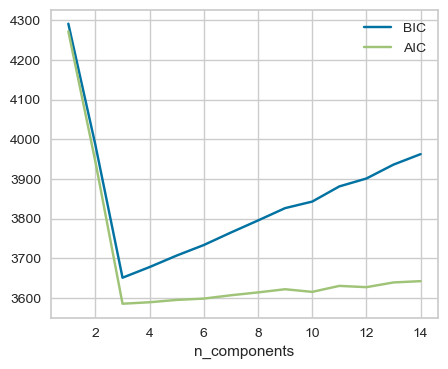

In [57]:
n_components = range(1,15)

gmm_models = [GaussianMixture(n_components=k).fit(X_train) for k in n_components]
aic_scores = [model.aic(X_train) for model in gmm_models]
bic_scores = [model.bic(X_train) for model in gmm_models]

data = np.vstack([n_components, aic_scores, bic_scores]).T
pd.DataFrame(data, columns=['n_components', 'aic', 'bic'])
np.argmin(bic_scores)
plt.plot(n_components, bic_scores, label='BIC')
plt.plot(n_components, aic_scores, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

Here, both AIC and BIC are smallest for `n_components=3`. See an example of using grid search to select the number of components using BIC [here](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py).

### ❓❓ Questions for you

### 1.4 Select all of the following statements which are **True** (iClicker)
**iClicker cloud join link: https://join.iclicker.com/NGJD**

- (A) GMMs are more flexible than KMeans but can be computationally expensive. 
- (B) In GMMs, each data point has a probability associated with each component. 
- (C) GMMs are sensitive to the initialization. 
- (D) The number of components in a GMM has no effect on the model's ability to fit the data. 

```{admonition} V's Solutions!
:class: tip, dropdown
- A, B, C
```

<br><br><br><br>

## 5. Final comments, summary, and reflection

### Important points to remember

- Clustering is a common unsupervised approach to identify underlying structure in data and grouping points based on similarity. 
- Appropriate data representation is crucial for meaningful clustering. 
- We did not talk much about distance metrics in this lecture but that is another importance consideration in clustering. We'll talk about it later in the course. 
- K-Means is a popular clustering algorithm. 

**Clustering with K-Means**
- It requires us to specify the number of clusters in advance. 
- Each example is assigned to one (and only one) cluster.
- The labels provided by the algorithm have no actual meaning. 
- The centroids live in the same space as of the dataset but they are **not** actual data points, but instead are average points.
- It always converges. Convergence is dependent upon the initial centers and it may converge to a sub-optimal solution. 
- Two popular ways to provide insight into how many clusters are reasonable for the give problem are: **the Elbow method** and **the Silhouette method**.  

**Clustering with Gaussian mixture models**

- Gaussian mixture models model the distribution of data as a mixture of $k$ Gaussian components. 
- Each Gaussian has a different mean vector and co-variance matrix and a weight associated with it, which control its location, shape, and complexity. 
- You can control and shape and complexity of the Gaussians by restricting the covariance matrix. There are four common ways to do this in `sklearn`: spherical, diag, tied, full 
- Gaussian mixture models are a probabilistic model; they assign a probability to each data point belonging to each cluster. In `sklearn`, we can access these soft assignments using `predict_proba` scores. 
- The model also gives us the log likelihood of fitting the data. It's possible to calculate AIC and BIC scores and pick the number of components where these scores are the lowest. 

- Some applications of clustering include data exploration, feature engineering, customer segmentation, and document clustering. 
- It takes fair amount of manual effort and domain knowledge to interpret clusters returned by clustering models. 

<br><br><br><br>

## Resources 
- ["Spaghetti Sauce" talk by Malcom Gladwell](https://www.ted.com/talks/malcolm_gladwell_on_spaghetti_sauce?language=en)
- [A Comprehensive Survey of Clustering Algorithms](https://link.springer.com/article/10.1007/s40745-015-0040-1)
- [Visualizing-k-means-clustering](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/) 
- [Visualizing K-Means algorithm with D3.js](http://tech.nitoyon.com/en/blog/2013/11/07/k-means/)
- [Clustering with Scikit with GIFs](https://dashee87.github.io/data%20science/general/Clustering-with-Scikit-with-GIFs/)
- [`sklearn` clustering documentation](https://scikit-learn.org/stable/modules/clustering.html)